# 훈련 후 동적 범위 양자화

* https://www.tensorflow.org/lite/performance/post_training_quant

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU[0] is ready')
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)
else:
    print('Please check GPU available')
    
import os
import sys
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from tensorflow import feature_column as fc
import tensorflow_datasets as tfds
plt.rcParams["font.family"] = 'NanumBarunGothic'
TENSORBOARD_BINARY = '/home/hoondori/anaconda3/envs/ai/bin/tensorboard'
os.environ['TENSORBOARD_BINARY'] =  TENSORBOARD_BINARY

GPU[0] is ready


In [2]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

# 일반 학습으로 MNIST 모델 생성 후 저장

In [3]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28)),
    keras.layers.Reshape(target_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)

1875/1875 [==============================] - 2s 855us/step - loss: 0.2697 - accuracy: 0.9268 - val_loss: 0.1126 - val_accuracy: 0.9684


# TensorFlow Lite 모델로 변환하기  (FP32)

In [4]:
tflite_models_dir = pathlib.Path("/tmp/logs/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp7yavggdg/assets


84452

In [6]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

# INT8 양자화된 모델로 저장하기 => 1/4 크기

In [7]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmp7xb2dhtv/assets


INFO:tensorflow:Assets written to: /tmp/tmp7xb2dhtv/assets


23840

In [8]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [9]:
# 입출력은 여전히 FP32
in_dtype = interpreter_quant.get_input_details()[0]['dtype']
out_dtype = interpreter_quant.get_output_details()[0]['dtype']
print(f'input dtype: {in_dtype}, output dtype: {out_dtype}')

input dtype: <class 'numpy.float32'>, output dtype: <class 'numpy.float32'>


# TensorFlow Lite 모델 실행하기

In [10]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)
print(f'test image shape: {test_images[0].shape}')

test image shape: (28, 28)


In [11]:
input_index = interpreter_quant.get_input_details()[0]["index"]
output_index = interpreter_quant.get_output_details()[0]["index"]
interpreter_quant.set_tensor(input_index, test_image)
interpreter_quant.invoke()
predictions = interpreter_quant.get_tensor(output_index)

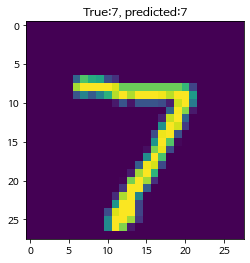

In [12]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

# FP32 모델 INT8 양자화 모델 평가 비교하기

In [13]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for test_image in test_images:
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    # Compare prediction results with ground truth labels to calculate accuracy.
    accurate_count = 0
    for index in range(len(prediction_digits)):
        if prediction_digits[index] == test_labels[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_digits)

    return accuracy

eval_fp32 = evaluate_model(interpreter)
eval_quant = evaluate_model(interpreter_quant)
print(f'fp32 acc: {eval_fp32}, INT8 acc: {eval_quant}')

fp32 acc: 0.9684, INT8 acc: 0.9684
